### Inference

In [129]:
import os
import json
import torch
import yaml
import time
import random
import pandas as pd
import re
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import string
from tqdm import tqdm
from bs4 import BeautifulSoup
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizer
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [130]:
class DatasetLoader(Dataset):
    
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        assert len(texts) == len(labels), "Length of texts and labels must be the same"
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoded_text = self.tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,
            max_length=120,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        label = torch.tensor(self.labels[idx])
        
        return (encoded_text['input_ids'].squeeze(0), encoded_text['attention_mask'].squeeze(0)), label



In [131]:
class CleanTweets:
    
    def __init__(self,texts):
        self.texts = texts
        self.cleaned_tweets = []
        
    def remove_urls(self,text):
        """
        Regular expression to match URLs and replace with empty string
        @param: String
        @return: String
        """
        url_pattern = re.compile(r'https?://\S+|www\.\S+|bit\.ly/\S+|t\.co/\S+|tinyurl\.\S+')
        return url_pattern.sub('', text)
    
    def remove_numbers(self,text):
        """
        Regular expression to match numbers and replace with empty string
        @param: String
        @return: String
        """
        numbers = re.compile(r'[0-9]+')
        
        # Replace number with an empty string
        return numbers.sub('',text)
    
    def remove_mentions(self,text):
        """
        Regular expression to match mentions and replace with empty string
        @param: String
        @return: String
        """
        mentions = re.compile(r'@[a-zA-Z0-9_]+')
        return mentions.sub('',text)
    
    def clean_html_tags(self,text):
        """
        Clean html tags off text using bs4
        @param: String
        @return: String
        """
        return BeautifulSoup(text).get_text()
    
    def handle_emoticons(self,text):
        """
        Regular expression for emoticons
        @param: String
        @return: String
        """
        emoticon_pattern = re.compile(r':([\w-]+):')
        modified_sentence = emoticon_pattern.sub(lambda match: ' '+match.group(1).replace('_', '')+' ', text)
        
        return re.sub(r'\s+', ' ', modified_sentence)
    
    def handle_acronyms(self,text):
        """
        Expand acronyms present in the tweets.
        @param: String
        @return: String
        """
        acronym_dict = {'afaik':'as far as i know','ama':'ask me anything','api':'application programming interface','asmr':'autonomous sensory meridian response','bc':'because'
                        ,'b2b':'business-to-business','b2c':'business-to-consumer','b4':'before','bae':'before anyone else',
                       'bff':'best friends forever','brb':'be right back','btaim':'be that as it may','bts':'behind the scenes','bwl':'bursting with laughter',
                       'btw':'by the way','cc':'carbon copy','cpc':'cost per click','csl':'cannot stop laughing','bftba':'do not forget to be awesome',
                       'f2f':'face to face','fb':'facebook','fomo':'fear of missing out','ftfy':'fixed that for you',
                       'ftw':'for the win','gg':'good game','gr8':'great','grwm':'get ready with me',
                       'goat':'greatest of all time','gtg':'got to go','gtr':'got to run','hbd':'happy birthday',
                       'hmb':'hit me back','hifw':'how i feel when','hmu':'hit me up','hth':'happy to help',
                       'idc':'i do not care','idk':'i do not know','ifyp':'i feel your pain','ig':'instagram','ikr':'i know right','ily':'i love you',
                       'im':'instant message','imho':'in my humble opinion','imo':'in my opinion','imu':'i miss you',
                       'irl':'in real life','jk':'just kidding','l8':'late','lamo': 'laughing my ass off','lmk':'let me know','lms':'like my status',
                       'lol':'laughing out loud','lolz':'laughing out loud','mcm':'man crush monday','mfw':'my face when',
                       'mm':'music monday','msg':'message','mtfbwy':'may the force be with you',
                       'nbd':'no big deal','nm':'not much','nsfl':'not safe for life','nsfw':'not safe for work',
                       'nvm':'never mind','oan':'on another note',
                       'omg':'oh my god','omw':'on my way',
                       'ootd':'outfit of the day','op':'original poster','otp':'one true pairing','potd':'photo of the day',
                       'ppc':'pay per click','pm':'private message','ppl':'people','pr':'pagerank','psa':'public service accouncement',
                       'qotd':'quote of the day','qq':'crying','rofl':'rolling on the floor laughing','roflmao':'rolling on the floor laughing my ass off',
                       'roi':'return on investment','rt':'retweet','sc':'snapchat','sem':'search engine marketing','sm':'social media','smh':'shaking my head','sus':'suspicious','tbh':'to be honest',
                       'tbt':'throwback thursday','tfw':'that feeling when','tgif':'thank goodness it is friday',
                       'thx':'thanks','til':'today i learned','tldr':'too long did not read','tmi':'too much information','tntl':'trying not to laugh',
                       'ttyl':'talk to you later','ttyn':'talk to you never','tw':'twitter','txt': 'text','wbu':'what about you ?','w/':'with','wcw':'women crush wednesday',
                       'wfh':'work from home','wdymbt':'what do you mean by that?','wom':'word of mouth','wotd':'word of the day',
                       'wywh':'wish you were here','ygtr':'you got that right','yolo':'you only live once','ysk':'you should know',
                       'yt':'youtube'}
        pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in acronym_dict.keys()) + r')\b')
        return pattern.sub(lambda match: acronym_dict[match.group(0)], text)
    
    def handle_contractions(self, text):
        """
        Expand contractions present in the tweets.
        @param: String
        @return: String
        """
        CONTRACTION_MAP = {
            "ain't": "is not", "aren't": "are not", "can't": "cannot",
            "can't've": "cannot have", "'cause": "because", "could've": "could have", "couldn't": "could not",
            "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not",
            "don't": "do not", "hadn't": "had not",
            "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", "he'd": "he would",
            "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "he's": "he is",
            "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would",
            "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am", "I've": "I have",
            "i'd": "i would", "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have",
            "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have",
            "it'll": "it will", "it'll've": "it will have",
            "it's": "it is",
            "let's": "let us",
            "ma'am": "madam",
            "mayn't": "may not",
            "might've": "might have",
            "mightn't": "might not",
            "mightn't've": "might not have",
            "must've": "must have",
            "mustn't": "must not",
            "mustn't've": "must not have",
            "needn't": "need not",
            "needn't've": "need not have",
            "o'clock": "of the clock",
            "oughtn't": "ought not",
            "oughtn't've": "ought not have",
            "shan't": "shall not",
            "sha'n't": "shall not",
            "shan't've": "shall not have",
            "she'd": "she would",
            "she'd've": "she would have",
            "she'll": "she will",
            "she'll've": "she will have",
            "she's": "she is",
            "should've": "should have",
            "shouldn't": "should not",
            "shouldn't've": "should not have",
            "so've": "so have",
            "so's": "so as",
            "that'd": "that would",
            "that'd've": "that would have",
            "that's": "that is",
            "there'd": "there would",
            "there'd've": "there would have",
            "there's": "there is",
            "they'd": "they would",
            "they'd've": "they would have",
            "they'll": "they will",
            "they'll've": "they will have",
            "they're": "they are",
            "they've": "they have",
            "to've": "to have",
            "wasn't": "was not",
            "we'd": "we would",
            "we'd've": "we would have",
            "we'll": "we will",
            "we'll've": "we will have",
            "we're": "we are",
            "we've": "we have",
            "weren't": "were not",
            "what'll": "what will",
            "what'll've": "what will have",
            "what're": "what are",
            "what's": "what is",
            "what've": "what have",
            "when's": "when is",
            "when've": "when have",
            "where'd": "where did",
            "where's": "where is",
            "where've": "where have",
            "who'll": "who will",
            "who'll've": "who will have",
            "who's": "who is",
            "who've": "who have",
            "why's": "why is",
            "why've": "why have",
            "will've": "will have",
            "won't": "will not",
            "won't've": "will not have",
            "would've": "would have",
            "wouldn't": "would not",
            "wouldn't've": "would not have",
            "y'all": "you all",
            "y'all'd": "you all would",
            "y'all'd've": "you all would have",
            "y'all're": "you all are",
            "y'all've": "you all have",
            "you'd": "you would",
            "you'd've": "you would have",
            "you'll": "you will",
            "you'll've": "you will have",
            "you're": "you are",
            "you've": "you have"
        }
        pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in CONTRACTION_MAP.keys()) + r')\b')
        return pattern.sub(lambda match: CONTRACTION_MAP[match.group(0)], text)

    def remove_punctuations(self, text):
        """
        Remove punctuations from the provided text
        @param: String
        @return: String
        """
        translator = str.maketrans("", "", string.punctuation)
        return text.translate(translator)
    
    def handle_hashtags(self,text):
        """
        Remove Hastags from the text
        @param: String
        @return: String
        """
        hashtag = re.compile(r'#')
        return hashtag.sub('',text)
    
    def clean_tweet(self):
        """
        Builder function to apply complete pre processing of a string
        @return: String
        """
        # Function to apply full preprocessing of the text
        for text in tqdm(self.texts):
            text = text.replace("\\'", "'")
            if text.startswith("b'") or text.startswith('b"'):
                text = text[2:-1]
            text = text.replace('\n', ' ').replace('\t', ' ').lower()
            rt_pattern = re.compile(r'^\s*rt\s+', re.IGNORECASE)
            text = rt_pattern.sub('', text)
            urls_removed = self.remove_urls(text)
            numbers_removed = self.remove_numbers(urls_removed)
            mentions_removed = self.remove_mentions(numbers_removed)
            html_removed = self.clean_html_tags(mentions_removed)
            hashtag_removed = self.handle_hashtags(html_removed)
            acronyms_expanded = self.handle_acronyms(hashtag_removed)
            contractions_expanded = self.handle_contractions(acronyms_expanded)
            emoticons_cleaned = self.handle_emoticons(contractions_expanded)
            punctuations_removed = self.remove_punctuations(emoticons_cleaned)
            self.cleaned_tweets.append(punctuations_removed.strip())
        return self.cleaned_tweets

In [132]:
if torch.backends.mps.is_available():
    DEVICE_TYPE = "mps"
else:
    DEVICE_TYPE = "cpu"

In [133]:
cnn_model = "CNN_Model"
lstm_tc_model = "LSTM_Text_Classifier"
mlp_class_model = "MLP_Classifier"
lstm_multihead = "LSTM_Multi_Head_Attention"
rcnn_model = "RCNN_Text_Classifier"
bigru_model = "BiGRU_Attention_Residual"
yml_file_path = "../src/configs/hyperparams.yaml"
SPLIT_DATA_FILEPATH = "../src/dataset/processed/split_data.json"

In [134]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer_vocab_size = tokenizer.vocab_size

In [135]:
def read_config_file(file_name,model_name):
    try:
        with open(file_name, "r") as yamlfile:
            data = yaml.load(yamlfile, Loader=yaml.FullLoader)
            if model_name:
                if model_name in data:
                    model_parameters = data[model_name]
            else:
                model_parameters = data
            return model_parameters
    except Exception as e:
        print(e)
        model_parameters = {}
        return model_parameters

In [136]:
def inference(model, test_loader, loss_fn, device=DEVICE_TYPE):
    """
    Function to make inference of the trained model. The function will display the classification report and also 
    the accuracy of each of the model
    """
    model.eval()
    total_loss, total_correct = 0, 0
    total_samples = 0
    all_preds, all_labels = [], []
    heads_count = 8
    with torch.no_grad():
        for test_batch_input, test_batch_label in test_loader:
            input_ids, attention_masks = [t.to(device) for t in test_batch_input]
            test_batch_label = test_batch_label.to(device)
            logits = model(input_ids)
            loss = loss_fn(logits, test_batch_label)
            total_loss += loss.item() * test_batch_label.size(0)
            preds = torch.argmax(logits, dim=1)
            test_batch_labels = torch.argmax(test_batch_label, dim=1)
            total_correct += (preds == test_batch_labels).sum().item()
            total_samples += test_batch_label.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(test_batch_labels.cpu().numpy())  
    avg_loss = total_loss / total_samples
    avg_accuracy = (total_correct / total_samples) * 100
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, digits=4, target_names=['angry', 'disappointed', 'happy'])
    average_attention_weights = []
    return avg_loss, avg_accuracy, average_attention_weights, cm, cr

In [137]:
def infer(model, loss_fn, file_name):
    try:
        with open(file_name, 'r', encoding='utf-8') as f:
            data = json.load(f)
        test_texts, test_labels = data['test_texts'], data['test_labels']
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        test_dataset = DatasetLoader(test_texts, test_labels,tokenizer)
        print("Number of records in test set is: ", len(test_dataset))
        num_cpus = os.cpu_count()
        test_loader = DataLoader(test_dataset, batch_size=128, num_workers=0)
        _, avg_accuracy, attention_weights, cm, cr = inference(model, test_loader, loss_fn, DEVICE_TYPE)
        print("Accuracy: ", avg_accuracy)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()
        print("Classification Report:\n", cr)
    except FileNotFoundError:
        raise Exception(f"The file {file_name} was not found.")
    except json.JSONDecodeError:
        raise Exception(f"The file {file_name} could not be decoded.")
    except Exception as e:
        raise Exception(f"An error occurred: {str(e)}")
        print("ERROR", e)

### Infer CNN Model

In [138]:
class CNN_Model(nn.Module):
    def __init__(self,
                 vocab_size,
                 embed_dim=256, 
                 filter_sizes=[3, 4, 5],
                 num_filters=[200, 250, 200],
                 num_classes=3,
                 dropout=0.5
                 ):
        super(CNN_Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=embed_dim, out_channels=num_filters[i],
                     kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        self.fc1 = nn.Linear(np.sum(num_filters), 256)     
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        x_embed = self.embedding(x)
        x_reshaped = x_embed.permute(0, 2, 1)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2]) for x_conv in x_conv_list]
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list], dim=1)
        fc1 = self.dropout(F.relu(self.fc1(x_fc)))
        logits = self.fc2(fc1)
        return logits

In [139]:
cnn_model_params = read_config_file(yml_file_path, cnn_model)
cnn_model_params['vocab_size'] = tokenizer_vocab_size

In [140]:
cnn_model = CNN_Model(**cnn_model_params)
optimizer = optim.Adadelta(cnn_model.parameters(), lr=0.01, rho=0.95)

In [141]:
loss_fn = nn.CrossEntropyLoss()

In [142]:
cnn_model.to(DEVICE_TYPE)

CNN_Model(
  (embedding): Embedding(30522, 128)
  (conv1d_list): ModuleList(
    (0): Conv1d(128, 64, kernel_size=(3,), stride=(1,))
    (1): Conv1d(128, 128, kernel_size=(4,), stride=(1,))
    (2): Conv1d(128, 256, kernel_size=(5,), stride=(1,))
  )
  (fc1): Linear(in_features=448, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [143]:
cnn_state_dict = torch.load('../src/models/CNN_Model')
cnn_model.load_state_dict(cnn_state_dict)

<All keys matched successfully>

Number of records in test set is:  137487
Accuracy:  88.6971131816099


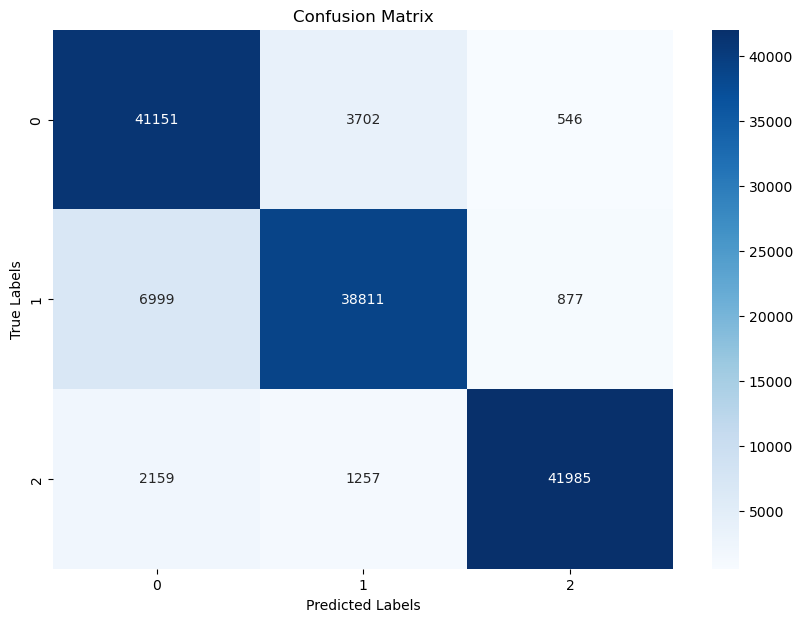

Classification Report:
               precision    recall  f1-score   support

       angry     0.8180    0.9064    0.8599     45399
disappointed     0.8867    0.8313    0.8581     46687
       happy     0.9672    0.9248    0.9455     45401

    accuracy                         0.8870    137487
   macro avg     0.8906    0.8875    0.8878    137487
weighted avg     0.8906    0.8870    0.8876    137487



In [144]:
infer(cnn_model, loss_fn, SPLIT_DATA_FILEPATH)

### Infer LSTM Text Classifier Model

In [145]:
class LSTM_Text_Classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        """
        Initialize the LSTMTextClassifier model.

        Parameters:
        @vocab_size: Size of the vocabulary.
        @embedding_dim: Dimension of the input embeddings.
        @hidden_dim: Dimension of the hidden state in the LSTM.
        @output_dim: Number of classes in the output layer.
        @n_layers: Number of layers in the LSTM.
        @bidirectional: If True, initializes a bidirectional LSTM.
        @dropout: Dropout rate for regularization.
        """
        super(LSTM_Text_Classifier, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Forward pass through the model.
        Params:
        @x: input_ids
        Returns: The logits for each class.
        """
        text_embeddings = self.embedding(x)
        lstm_out, (hidden,cell) = self.lstm(text_embeddings)
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
        hidden = self.dropout(hidden)
        logits = self.fc(hidden)
        return logits

In [146]:
lstm_model_params = read_config_file(yml_file_path, lstm_tc_model)
lstm_model_params['vocab_size'] = tokenizer_vocab_size

In [147]:
lstm_model = LSTM_Text_Classifier(**lstm_model_params)
lstm_optimizer = optim.Adadelta(lstm_model.parameters(), lr=0.01, rho=0.95)

In [148]:
loss_fn = nn.CrossEntropyLoss()
lstm_model.to(DEVICE_TYPE)

LSTM_Text_Classifier(
  (embedding): Embedding(30522, 128)
  (lstm): LSTM(128, 128, num_layers=6, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [62]:
lstm_state_dict = torch.load('../src/models/LSTM_Text_Classifier')
lstm_model.load_state_dict(lstm_state_dict)

<All keys matched successfully>

Number of records in test set is:  137487
Accuracy:  89.29716991424644


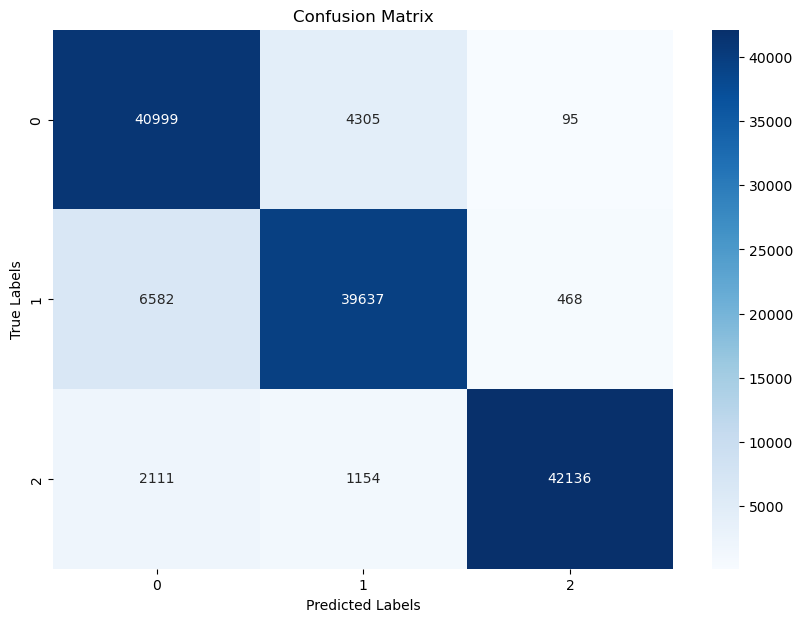

Classification Report:
               precision    recall  f1-score   support

       angry     0.8251    0.9031    0.8623     45399
disappointed     0.8789    0.8490    0.8637     46687
       happy     0.9868    0.9281    0.9565     45401

    accuracy                         0.8930    137487
   macro avg     0.8969    0.8934    0.8942    137487
weighted avg     0.8968    0.8930    0.8939    137487



In [63]:
infer(lstm_model, loss_fn, SPLIT_DATA_FILEPATH)

### Infer MLP Classifier Model

In [80]:
class MLP_Classifier(nn.Module):
    def __init__(self, vocab_size, input_dim, hidden_size, num_classes=2, dropout=0.5):
        """
        Params:
        @vocab_size: Size of the vocabulary.
        @input_dim: Dimension of the input embeddings.
        @hidden_dim: Dimension of the hidden state in the LSTM.
        @num_classes: Number of classes in the output layer.
        @dropout: Dropout rate for regularization.
        """
        super(MLP_Classifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, input_dim)
        self.fc1 = nn.Linear(input_dim * 120, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.fc4 = nn.Linear(hidden_size // 4, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embeddings = self.embedding(x)
        x = embeddings.view(embeddings.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x


In [81]:
mlp_model_params = read_config_file(yml_file_path, mlp_class_model)
mlp_model_params['vocab_size'] = tokenizer_vocab_size

In [82]:
mlp_model = MLP_Classifier(**mlp_model_params)
mlp_optimizer = optim.Adadelta(mlp_model.parameters(), lr=0.01, rho=0.95)

In [149]:
loss_fn = nn.CrossEntropyLoss()
mlp_model.to(DEVICE_TYPE)

MLP_Classifier(
  (embedding): Embedding(30522, 128)
  (fc1): Linear(in_features=15360, out_features=2048, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [150]:
mlp_model_state_dict = torch.load('../src/models/MLP_Classifier')
mlp_model.load_state_dict(mlp_model_state_dict)

<All keys matched successfully>

Number of records in test set is:  137487
Accuracy:  73.87389353175209


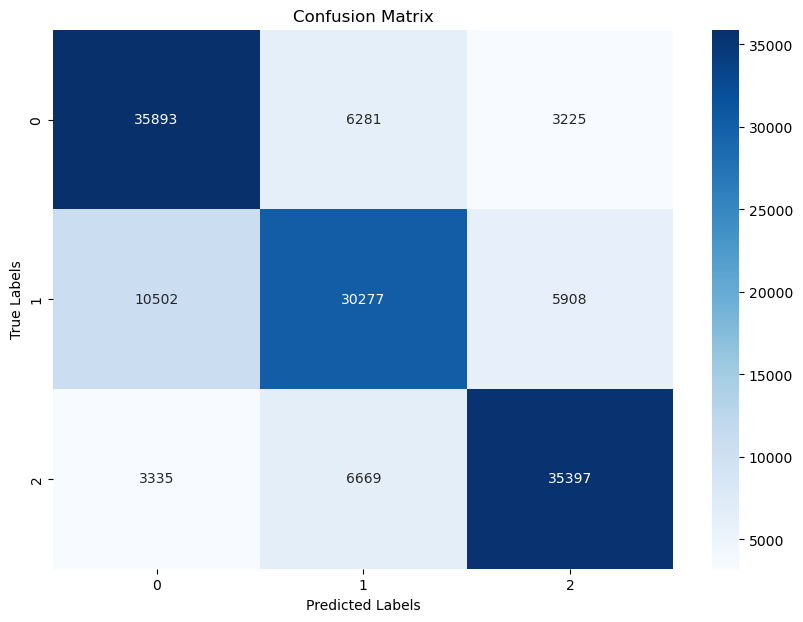

Classification Report:
               precision    recall  f1-score   support

       angry     0.7218    0.7906    0.7546     45399
disappointed     0.7004    0.6485    0.6735     46687
       happy     0.7949    0.7797    0.7872     45401

    accuracy                         0.7387    137487
   macro avg     0.7390    0.7396    0.7384    137487
weighted avg     0.7387    0.7387    0.7378    137487



In [151]:
infer(mlp_model, loss_fn, SPLIT_DATA_FILEPATH)

### Infer LSTM Multi Head Attention Model

In [152]:
class LSTM_Multi_Head_Attention(nn.Module):
    def __init__(self, vocab_size, input_dim, hidden_dim, output_dim, num_layers, bidirectional , dropout,
                num_heads):
        """
        Params:
        @vocab_size: Size of the vocabulary.
        @embedding_dim: Dimension of the input embeddings.
        @hidden_dim: Dimension of the hidden state in the LSTM.
        @output_dim: Number of classes in the output layer.
        @n_layers: Number of layers in the LSTM.
        @bidirectional: If True, initializes a bidirectional LSTM.
        @dropout: Dropout rate for regularization.
        """
        super(LSTM_Multi_Head_Attention, self).__init__()
        self.embedding = nn.Embedding(vocab_size, input_dim)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, bidirectional=self.bidirectional, batch_first=True, dropout=dropout)
        
        # Attention Layer
        if self.bidirectional:
            self.head_dim = hidden_dim * 2 // num_heads
        else:
            self.head_dim = hidden_dim // num_heads
        assert self.hidden_dim % num_heads == 0, "hidden_dim must be divisible by the number of heads"
        if self.bidirectional:
            self.query_layers = nn.ModuleList([nn.Linear(hidden_dim * 2, self.head_dim) for _ in range(self.num_heads)])
            self.key_layers = nn.ModuleList([nn.Linear(hidden_dim * 2, self.head_dim) for _ in range(self.num_heads)])
            self.value_layers = nn.ModuleList([nn.Linear(hidden_dim * 2, self.head_dim) for _ in range(self.num_heads)])
        elif not self.bidirectional:
            self.query_layers = nn.ModuleList([nn.Linear(hidden_dim, self.head_dim) for _ in range(self.num_heads)])
            self.key_layers = nn.ModuleList([nn.Linear(hidden_dim, self.head_dim) for _ in range(self.num_heads)])
            self.value_layers = nn.ModuleList([nn.Linear(hidden_dim, self.head_dim) for _ in range(self.num_heads)])
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.last_attention_weights = None
        self.dropout = nn.Dropout(p=dropout)

    def attention_net(self, lstm_outputs):
        """
        Multi-Head Attention mechanism
        """
        attention_outputs = []
        attention_scores = []
        for i in range(self.num_heads):
            Q = self.query_layers[i](lstm_outputs)
            Q = self.dropout(Q)
            K = self.key_layers[i](lstm_outputs)
            K = self.dropout(K)
            V = self.value_layers[i](lstm_outputs)
            V = self.dropout(V)
            scores = torch.bmm(Q, K.transpose(1, 2)) / (self.head_dim ** 0.5)
            scores = F.softmax(scores, dim=-1)
            output = torch.bmm(scores, V)
            attention_scores.append(scores)
            attention_outputs.append(output)
        final_output = torch.cat(attention_outputs, dim=-1)
        self.last_attention_weights = attention_scores
        return final_output, attention_scores
            
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_().to(DEVICE_TYPE)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).requires_grad_().to(DEVICE_TYPE)
        x = self.embedding(x)
        lstm_out, (hn, cn) = self.lstm(x, (h0.detach(),c0.detach()))
        attention_output, attention_weights = self.attention_net(lstm_out)
        final_attention_output = torch.mean(attention_output, dim=1)
        out = self.fc(final_attention_output)
        return out

In [153]:
lstm_mh_model_params = read_config_file(yml_file_path, lstm_multihead)
lstm_mh_model_params['vocab_size'] = tokenizer_vocab_size

In [154]:
lstm_mh_model = LSTM_Multi_Head_Attention(**lstm_mh_model_params)
lstm_mh_optimizer = optim.Adadelta(lstm_mh_model.parameters(), lr=0.01, rho=0.95)

In [155]:
loss_fn = nn.CrossEntropyLoss()
lstm_mh_model.to(DEVICE_TYPE)

LSTM_Multi_Head_Attention(
  (embedding): Embedding(30522, 128)
  (lstm): LSTM(128, 128, num_layers=6, batch_first=True, dropout=0.5, bidirectional=True)
  (query_layers): ModuleList(
    (0-7): 8 x Linear(in_features=256, out_features=32, bias=True)
  )
  (key_layers): ModuleList(
    (0-7): 8 x Linear(in_features=256, out_features=32, bias=True)
  )
  (value_layers): ModuleList(
    (0-7): 8 x Linear(in_features=256, out_features=32, bias=True)
  )
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [156]:
lstm_mh_model_state_dict = torch.load('../src/models/LSTM_Multi_Head_Attention')
lstm_mh_model.load_state_dict(lstm_mh_model_state_dict)

<All keys matched successfully>

Number of records in test set is:  137487
Accuracy:  89.38663291802133


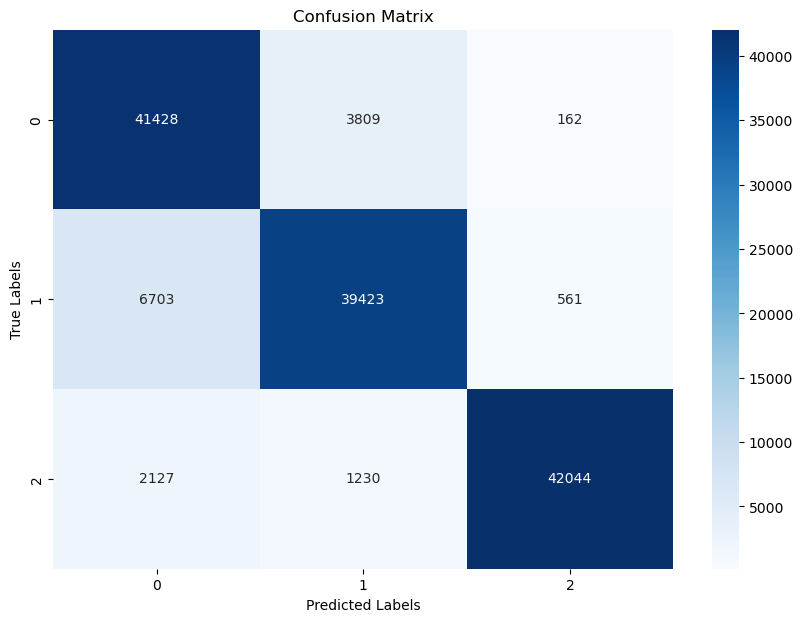

Classification Report:
               precision    recall  f1-score   support

       angry     0.8243    0.9125    0.8662     45399
disappointed     0.8867    0.8444    0.8650     46687
       happy     0.9831    0.9261    0.9537     45401

    accuracy                         0.8939    137487
   macro avg     0.8980    0.8943    0.8950    137487
weighted avg     0.8979    0.8939    0.8947    137487



In [157]:
infer(lstm_mh_model, loss_fn, SPLIT_DATA_FILEPATH)

### Infer RCNN Text Classifier Model (LSTM + CNN Combination)

In [158]:
class RCNN_Text_Classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, output_dim=3, dropout=0.5):
        """
        RCNN model combining LSTM and CNN.

        Params:
        @vocab_size: Size of vocabulary.
        @embedding_dim: Dimension of input embeddings.
        @hidden_dim: Hidden state size for LSTM.
        @output_dim: Number of output classes.
        @dropout: Dropout rate.
        """
        super(RCNN_Text_Classifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, bidirectional=True, batch_first=True)
        self.conv = nn.Conv1d(in_channels=embedding_dim + 2 * hidden_dim, out_channels=128, kernel_size=3, padding=1)
        self.fc = nn.Linear(128, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embeddings = self.embedding(x)
        lstm_out, _ = self.lstm(embeddings)
        combined = torch.cat([embeddings, lstm_out], dim=2)
        combined = combined.permute(0, 2, 1)
        conv_out = F.relu(self.conv(combined))
        pooled = F.max_pool1d(conv_out, kernel_size=conv_out.shape[2]).squeeze(2)
        dropped = self.dropout(pooled)
        logits = self.fc(dropped)
        return logits


In [159]:
rcnn_model_params = read_config_file(yml_file_path, rcnn_model)
rcnn_model_params['vocab_size'] = tokenizer_vocab_size

In [160]:
rcnn_model = RCNN_Text_Classifier(**rcnn_model_params)
rcnn_optimizer = optim.Adadelta(rcnn_model.parameters(), lr=0.01, rho=0.95)

In [161]:
loss_fn = nn.CrossEntropyLoss()
rcnn_model.to(DEVICE_TYPE)

RCNN_Text_Classifier(
  (embedding): Embedding(30522, 128)
  (lstm): LSTM(128, 128, batch_first=True, bidirectional=True)
  (conv): Conv1d(384, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [162]:
rcnn_model_state_dict = torch.load('../src/models/RCNN_Text_Classifier')
rcnn_model.load_state_dict(rcnn_model_state_dict)

<All keys matched successfully>

Number of records in test set is:  137487
Accuracy:  90.50673881894288


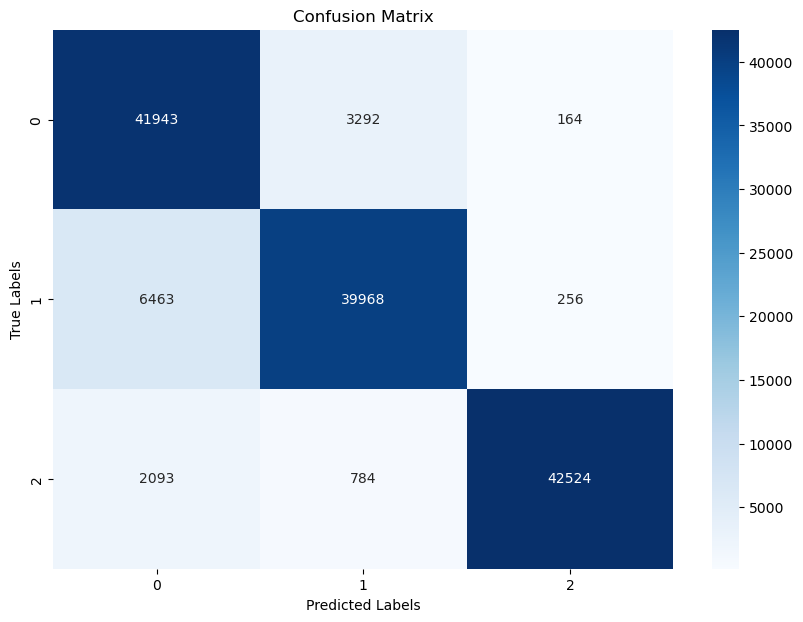

Classification Report:
               precision    recall  f1-score   support

       angry     0.8306    0.9239    0.8747     45399
disappointed     0.9075    0.8561    0.8810     46687
       happy     0.9902    0.9366    0.9627     45401

    accuracy                         0.9051    137487
   macro avg     0.9094    0.9055    0.9061    137487
weighted avg     0.9094    0.9051    0.9059    137487



In [163]:
infer(rcnn_model, loss_fn, SPLIT_DATA_FILEPATH)

## Infer BiGRU Attention Residual Model

In [164]:
class BiGRU_Attention_Residual(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=2, dropout=0.5):
        """
        Stacked BiGRU with Attention and Residual Connections for text classification.

        Params:
        @vocab_size: Size of vocabulary.
        @embedding_dim: Dimension of the input embeddings.
        @hidden_dim: Hidden state size of GRU.
        @output_dim: Number of output classes.
        @n_layers: Number of stacked GRU layers.
        @dropout: Dropout rate.
        """
        super(BiGRU_Attention_Residual, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigru = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers, 
                            bidirectional=True, dropout=dropout, batch_first=True)
        
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.residual_proj = nn.Linear(embedding_dim, hidden_dim * 2)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        """
        Forward pass for the model.

        @x: Input token ids tensor of shape [batch_size, seq_len]
        Returns: Logits tensor of shape [batch_size, output_dim]
        """
        embedded = self.embedding(x)
        gru_out, _ = self.bigru(embedded) 

        # Residual connection (project input embedding to match GRU output dim)
        residual = self.residual_proj(embedded) 
        gru_out += residual

        # Attention weights
        attention_scores = self.attention(gru_out).squeeze(-1)
        attention_weights = F.softmax(attention_scores, dim=1).unsqueeze(1) 

        # Context vector
        context_vector = torch.bmm(attention_weights, gru_out).squeeze(1) 

        output = self.dropout(context_vector)
        logits = self.fc(output) 

        return logits


In [165]:
bigru_model_params = read_config_file(yml_file_path, bigru_model)
bigru_model_params['vocab_size'] = tokenizer_vocab_size

In [166]:
bigruu_model = BiGRU_Attention_Residual(**bigru_model_params)
bigru_optimizer = optim.Adadelta(bigruu_model.parameters(), lr=0.01, rho=0.95)

In [126]:
loss_fn = nn.CrossEntropyLoss()
bigruu_model.to(DEVICE_TYPE)

BiGRU_Attention_Residual(
  (embedding): Embedding(30522, 128)
  (bigru): GRU(128, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (attention): Linear(in_features=256, out_features=1, bias=True)
  (residual_proj): Linear(in_features=128, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

In [127]:
bigruu_model_state_dict = torch.load('../src/models/BiGRU_Attention_Residual')
bigruu_model.load_state_dict(bigruu_model_state_dict)

<All keys matched successfully>

Number of records in test set is:  137487
Accuracy:  89.76048644599126


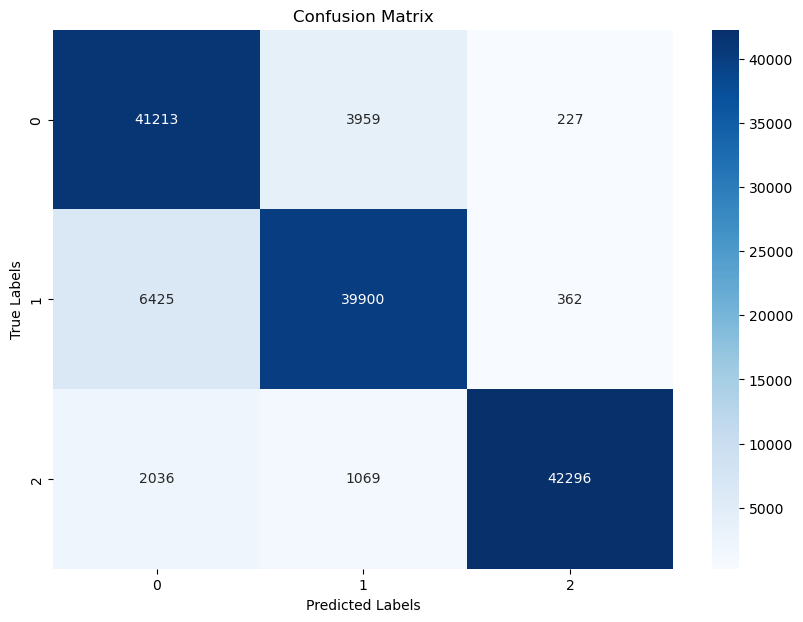

Classification Report:
               precision    recall  f1-score   support

       angry     0.8297    0.9078    0.8670     45399
disappointed     0.8881    0.8546    0.8710     46687
       happy     0.9863    0.9316    0.9582     45401

    accuracy                         0.8976    137487
   macro avg     0.9013    0.8980    0.8987    137487
weighted avg     0.9012    0.8976    0.8985    137487



In [128]:
infer(bigruu_model, loss_fn, SPLIT_DATA_FILEPATH)

### Predictions

In [102]:
def predict(input_text, model):
    input_text = [input_text]
    cleaned_tweet = CleanTweets(input_text).clean_tweet()
    print("Cleaned Tweet: ", cleaned_tweet)
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    encoded_text = tokenizer.encode_plus(
        cleaned_tweet,
        add_special_tokens=True,
        max_length=120,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    token_ids, atten_masks = encoded_text['input_ids'].squeeze(0), encoded_text['attention_mask'].squeeze(0)
    vocab_size = tokenizer.vocab_size
    if model == 'CNN':
        model_params = read_config_file(yml_file_path, 'CNN_Model')
        model_params['vocab_size'] = vocab_size
        model = CNN_Model(**model_params)
        model.load_state_dict(torch.load('../src/models/CNN_Model'))
    elif model == 'LSTM':
        model_params = read_config_file(yml_file_path, 'LSTM_Text_Classifier')
        model_params['vocab_size'] = vocab_size
        model = LSTM_Text_Classifier(**model_params)
        model.load_state_dict(torch.load('../src/models/LSTM_Text_Classifier'))
    elif model == 'MLP':
        model_params = read_config_file(yml_file_path, 'MLP_Classifier')
        model_params['vocab_size'] = vocab_size
        model = MLP_Classifier(**model_params)
        model.load_state_dict(torch.load('../src/models/MLP_Classifier'))
    elif model == 'RCNN':
        model_params = read_config_file(yml_file_path, 'RCNN_Text_Classifier')
        model_params['vocab_size'] = vocab_size
        model = RCNN_Text_Classifier(**model_params)
        model.load_state_dict(torch.load('../src/models/RCNN_Text_Classifier'))
    elif model == 'BiGRU':
        model_params = read_config_file(yml_file_path, 'BiGRU_Attention_Residual')
        model_params['vocab_size'] = vocab_size
        model = BiGRU_Attention_Residual(**model_params)
        model.load_state_dict(torch.load('../src/models/BiGRU_Attention_Residual'))
    else:
        model_params = read_config_file(yml_file_path, 'LSTM_Multi_Head_Attention')
        model_params['vocab_size'] = vocab_size
        model = LSTM_Multi_Head_Attention(**model_params)
        model.load_state_dict(torch.load('../src/models/LSTM_Multi_Head_Attention'))
    
    model.to(DEVICE_TYPE)
    token_ids = token_ids.to(DEVICE_TYPE)
    model.eval()
    with torch.no_grad():
        output = model(token_ids.unsqueeze(0))
        prediction = torch.argmax(output, dim=1).item()
        print("output", output)
        print("prediction", prediction)
    return prediction

In [40]:
def get_prediction(input_text, model_name):
    predictions = predict(input_text, model_name)
    pred_dict = {0: 'Angry', 1:'Disappointed', 2:'Happy'}
    model_pred = pred_dict[int(predictions)]
    return model_pred

### CNN Model Predictions

In [245]:
input_text = "I can't believe you let me down again—I really expected better from you."
model_name = "CNN"

In [246]:
print("Prediction: ", get_prediction(input_text, model_name))

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 582.38it/s]


Cleaned Tweet:  ['i cannot believe you let me down again—i really expected better from you']
output tensor([[ 0.6529,  0.5327, -0.9716]], device='mps:0')
prediction 0
Prediction:  Angry


### LSTM Text Classifier Model Predictions

In [253]:
input_text = "I can't believe you let me down again—I really expected better from you."
model_name = "LSTM"

In [254]:
print("Prediction: ", get_prediction(input_text, model_name))

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 594.18it/s]


Cleaned Tweet:  ['i cannot believe you let me down again—i really expected better from you']
output tensor([[-0.0217,  0.0264, -0.0153]], device='mps:0')
prediction 1
Prediction:  Disappointed


### MLP Model Predictions

In [257]:
input_text = "I am absolutely pissed off"
model_name = "MLP"

In [258]:
print("Prediction: ", get_prediction(input_text, model_name))

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 183.41it/s]


Cleaned Tweet:  ['i am absolutely pissed off']
output tensor([[ 0.8604, -0.1291, -0.7487]], device='mps:0')
prediction 0
Prediction:  Angry


### LSTM Multi Head Attention Model Predictions

In [178]:
input_text = "I can't believe you let me down again—I really expected better from you."
model_name = "LSTM_MH"

In [179]:
print("Prediction: ", get_prediction(input_text, model_name))

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 463.82it/s]


Prediction:  Disappointed


### RCNN Predictions

In [191]:
input_text = "i miss my guitar"
model_name = "LSTM_MH"

In [192]:
print("Prediction: ", get_prediction(input_text, model_name))

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 624.62it/s]


output tensor([[-0.0105,  0.0413, -0.0053]], device='mps:0')
prediction 1
Prediction:  Disappointed


## BiGRU Predictions

In [43]:
input_text = "I can't believe you let me down again—I really expected better from you."
model_name = "BiGRU"

In [44]:
print("Prediction: ", get_prediction(input_text, model_name))

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1098.85it/s]


Cleaned Tweet:  ['i cannot believe you let me down again—i really expected better from you']
output tensor([[ 0.9686, -0.3276, -1.5236]], device='mps:0')
prediction 0
Prediction:  Angry
